In [1]:
import cx_Oracle
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_blobs

In [2]:
con = cx_Oracle.connect('DAISY/"62368102Dc"')
cur = con.cursor()
cur.execute('drop table beeGenes')

cur.execute('''create table beeGenes (
                gi varchar2(10),
                sequence clob,
                freq_A number,
                freq_T number,
                freq_GC number)''')
cur.bindarraysize = 50
#see maxNum.py for max seq size
cur.setinputsizes(10,14440,float,float,float,float,float)
#read raw data from a file
infile=file('honeybee_gene_sequences.txt','r')
myStr = ""
finalStr = ''

#form a string with the raw data
for aline in infile:
    if aline.startswith('>gi|'):
        aline = aline +'_**gene_seq_starts_here**_'
    myStr = myStr + aline

#form a continuous string
strL=myStr.replace('\n','')

#change the string into a list, one protein per list item
aList = strL.split('>')


#keep the list items that contains the substring, Apis mellifera    
for anItem in aList:
    if 'Apis mellifera' in anItem:
        finalStr = finalStr +anItem
            

end=0
totalLength = len(finalStr)
repetitions = finalStr.count('_**gene_seq_starts_here**_')
cur1=con.cursor()
#extract the target substrings, the gi number and the protein sequence
for i in range(repetitions):

    start = finalStr.find('gi|', end) +3
    end = finalStr.find('|', start)
    gi = finalStr[start : end]
    #print 'gi= ', gi
    start = finalStr.find('_**gene_seq_starts_here**_',end) +26
    end = finalStr.find('gi|',start)

    if end == -1:
        end = totalLength
    seq = finalStr[start:end]
    #print 'seq=', seq
    seqLength = len(seq)
    freq_A = seq.count('A')/float(seqLength)
    freq_T = seq.count('T')/float(seqLength)
    freq_GC = seq.count('GC')/float(seqLength)

    cur1.execute('''insert into beeGenes (gi, sequence, freq_A, freq_T, freq_GC) values(:v1,:v2,:v3,:v4,:v5)''', (gi, seq, freq_A, freq_T, freq_GC))
    

cur1.execute('''select freq_A, freq_T, freq_GC from beeGenes''')

res = cur1.fetchall()
dataset = np.array(res)

con.commit()

cur.close()
cur1.close()
con.close()

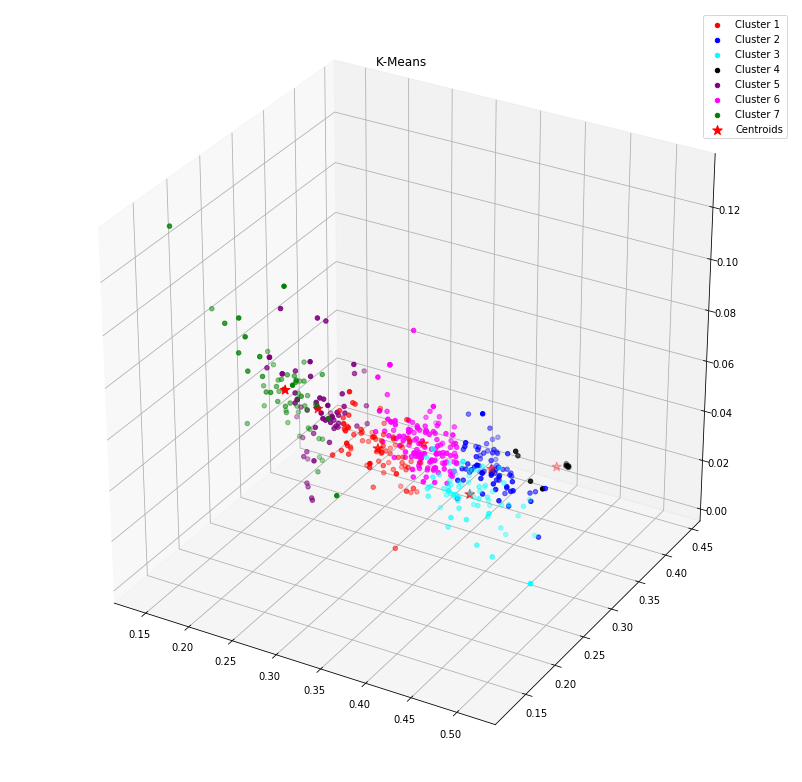

In [3]:
km = KMeans(n_clusters=7, init='random', n_init=10, max_iter=500, tol=1e-4, random_state=0)
X = dataset
y_km = km.fit_predict(dataset)
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(111, projection ='3d')

ax1.scatter(X[y_km ==0,0], X[y_km ==0,1], X[y_km ==0,2], s = 20, c = 'red', marker = 'o', label = 'Cluster 1')
ax1.scatter(X[y_km ==1,0], X[y_km ==1,1], X[y_km ==1,2], s = 20, c = 'blue', marker='o', label = 'Cluster 2')
ax1.scatter(X[y_km ==2,0], X[y_km ==2,1], X[y_km ==2,2], s = 20, c = 'aqua', marker = 'o', label = 'Cluster 3')
ax1.scatter(X[y_km ==3,0], X[y_km ==3,1], X[y_km ==3,2], s = 20, c = 'black', marker = 'o', label = 'Cluster 4')
ax1.scatter(X[y_km ==4,0], X[y_km ==4,1], X[y_km ==4,2], s = 20, c = 'purple', marker = 'o', label = 'Cluster 5')
ax1.scatter(X[y_km ==5,0], X[y_km ==5,1], X[y_km ==5,2], s = 20, c = 'magenta', marker = 'o', label = 'Cluster 6')
ax1.scatter(X[y_km ==6,0], X[y_km ==6,1], X[y_km ==6,2], s = 20, c = 'green', marker = 'o', label = 'Cluster 7')
ax1.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],km.cluster_centers_[:,2],s=100, marker = '*', c='red', label = 'Centroids')
ax1.set_title('K-Means')
ax1.legend(loc=1)
plt.grid()